In [23]:
# --- Imports ---
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [24]:
# --- Convert .pgm to cleaned .png (white stays, others become black) ---
def convert_clean_pgm_to_png(pgm_path, png_path,white_threshold=240):
    img = Image.open(pgm_path).convert('L')
    img_array = np.array(img)

    # Set all non-white pixels to black
    cleaned = np.where(img_array >= white_threshold, 255, 0).astype(np.uint8)
    cleaned_img = Image.fromarray(cleaned)
    cleaned_img.save(png_path)


In [25]:
def pad_image(png_path, padded_path, cell_size=5):
    img = Image.open(png_path).convert('L')
    img_array = np.array(img)

    h, w = img_array.shape
    pad_h = (cell_size - (h % cell_size)) % cell_size
    pad_w = (cell_size - (w % cell_size)) % cell_size

    # Pad with black pixels (0) at bottom and right
    padded_array = np.pad(
        img_array,
        ((0, pad_h), (0, pad_w)),
        mode='constant',
        constant_values=0
    )

    padded_img = Image.fromarray(padded_array)
    padded_img.save(padded_path)



In [26]:
# --- Convert cleaned PNG to 5x5 grid ---
def png_to_grid(padded_path, cell_size=5, output_txt="grid_cropped.txt"):
    img = Image.open(padded_path).convert('L')
    img_array = np.array(img)
    h, w = img_array.shape

    new_h = h // cell_size
    new_w = w // cell_size
    img_array = img_array[:new_h * cell_size, :new_w * cell_size]

    # Reshape into (rows, cell_size, cols, cell_size)
    reshaped = img_array.reshape(new_h, cell_size, new_w, cell_size)

    # Use min to check if any pixel is black (0) → set cell to 1 (obstacle)
    cell_min = reshaped.min(axis=(1, 3))
    grid = (cell_min < 255).astype(int)
    
      # --- Remove outer rows/columns that are all 1s ---
    row_mask = ~(grid == 1).all(axis=1)
    col_mask = ~(grid == 1).all(axis=0)
    trimmed_grid = grid[np.ix_(row_mask, col_mask)]

    # --- Save to txt file ---
    np.savetxt(output_txt, trimmed_grid, fmt="%d", delimiter=" ")
    print(f"Trimmed grid saved to {output_txt}")
    return trimmed_grid


In [27]:
# --- Visualize grid ---
def show_grid(grid):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(grid, cmap='gray_r', interpolation='nearest')

    # Draw green grid lines
    rows, cols = grid.shape
    for x in range(cols + 1):
        ax.axvline(x - 0.5, color='green', linewidth=0.5)
    for y in range(rows + 1):
        ax.axhline(y - 0.5, color='green', linewidth=0.5)

    ax.set_title("5x5 Grid Map with Gridlines")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()


In [28]:
def save_grid_as_png(grid, output_path):
    img_array = np.where(grid == 0, 255, 0).astype(np.uint8)
    img = Image.fromarray(img_array, mode='L')
    img.save(output_path)


Trimmed grid saved to grid_cropped.txt


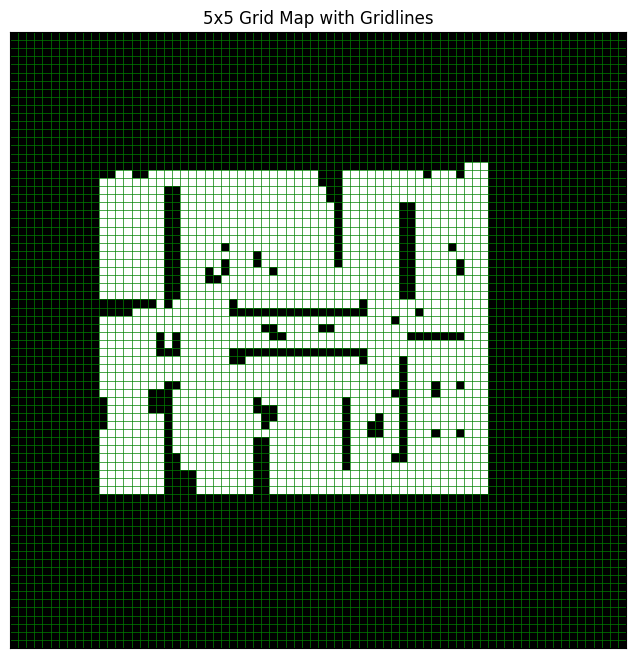

In [29]:
# --- Run all steps ---
pgm_path = 'map.pgm'  
png_path = 'map_cleaned.png'

convert_clean_pgm_to_png(pgm_path, png_path)
png_path = 'map_cleaned.png'
padded_path = 'map_padded.png'
pad_image(png_path, padded_path)
grid = png_to_grid(png_path, cell_size=5)
show_grid(grid)

save_grid_as_png(grid, 'final_grid.png')
